In [2]:
import pandas as pd
import numpy as np
#import re
import regex as re 
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from estnltk import Text

import time

In [356]:
#!pip install bertopic
#!pip install joblib
#nltk.download('omw-1.4')

In [4]:
df = pd.read_excel('../fb_data_clean/fb_df_2.xlsx')
df.head()

,nimi,erakond,kuupäev,postitus
0,E200,E200,2023-03-28 19:11:46,"Täna andsime pressikonverentsi, milles teatasime läbirääkimiste hetkeseisust.👀\nEesti 200 toetab jätkuvalt abieluvõrdsust, kuid põhjalik arutelu seisab tõepoolest veel ees. Oleme saanud ette ka pildi, milline on riigi rahaline seis. Lauri Hussari sõnul on olukord seotud varasemate valitsuste kulutustega. ""Aastatel 2018 kuni 2021 on riigi rahandusele lähenetud pehmelt öeldes loominguliselt. See on suuresti tinginud selle, et eelarvemiinus on märkimisväärne ja peame leidma lahendusi, kuidas eelarvemiinust kärpida,"" ütles ta."
1,E200,E200,2023-03-27 17:05:40,"Palju õnne sünnipäevaks, president Karis!🎈\nTäna käisime ja soovisime õnne härra presidendile. Vastselt Riigikogusse valitud Eesti 200 esindajad Kadri Tali ja Toomas Uibo ning erakonna tegevjuht Kadri Napritson-Acuña kinkisid Alar Karisele meie poolt omapärase kingituse. Anna kommentaarides teada, mis see olla võis. Võitjate vahel loosime välja vihmavarju. ☂️"
2,E200,E200,2023-03-25 08:51:45,Meeleolukas lugemine laupäeva... 👋🏼
3,E200,E200,2023-03-24 14:41:20,"Võtame erakondade rahastuse luubi alla!💰\n💶Tugevdame erakondade järelevalvet, et rahastusmudel oleks läbipaistvam.\n💶Suurendame liikmemaksude osakaalu.\n💶Illegaalse annetuse puhul tagastatakse annetus riigikassasse, mitte sellele, kes annetuse tegi - kui annetad illegaalselt, siis ei saa raha tagasi!"
4,E200,E200,2023-03-24 10:31:31,"Kui praegu kehtib koolikohustus 17-aastaseks või põhikooli lõpudiplomi saamiseni, siis loodav koalitsioon kavatseb seda tõsta 18-aastaseks saamiseni või kuni kutse omandamiseni. Kas toetame seda plaani? Milliseid meetmeid tuleks õpilaste koolidest väljalangemise vähendamiseks veel kaaluda?🤔\nVastab Liisa Pakosta:\n""Vähemalt 2400 alaealist noort ei õpi ega tööta. Sellel on suuresti kaks põhjust: pole erivajadusi arvestavat õppekohta või on noore püüdlused pere või senise kooli poolt juba maha tambitud. Mõlema murekoha vastu aitab õppimiskohustuse pikendamine täisealiseks saamiseni või kui keegi jõuab kutse omandamiseni enne seda, siis selleni.\nÕppimiskohustus tähendab seda, et enne põhikooli lõpetamist vaadatakse koos noorega tema edasine tee läbi - kas ta jätkab gümnaasiumis, kutsekoolis või saab vajaliku väljaõppe näiteks töökohal. Kõik see eeldab nii senisest paindlikumaid õppimisvõimalusi kui ka erivajadustega noorte edasiõppimise täiesti loomulikuks pidamist.\nÕppimiskohustus peab kaasa tooma ka põhikoolijärgse hariduse omandamise kulude vähenemise. Madalast enesehinnangust ja pere toetuse puudumisest tulenev lootusetusetunne väheneb õppimiskohustuse sisseviimisel samuti - kui põhikooli järel on ühel või teisel moel edasi õppimine lapseealistele kohustuslik, siis ei saa pere ega senine kool enam öelda, et sa niikuinii ei saa millegagi hakkama. Muutus, mida tahame, on iga noore väärtustamine ja igale noorele võimaluste andmine."""


In [358]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14829 entries, 0 to 14828
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   nimi      14829 non-null  object        
 1   erakond   14829 non-null  object        
 2   kuupäev   14829 non-null  datetime64[ns]
 3   postitus  14829 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 463.5+ KB


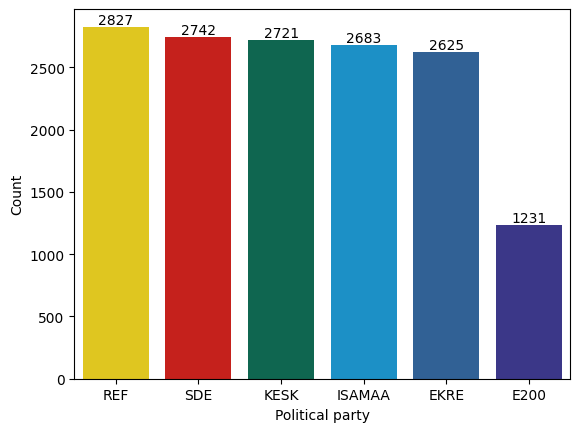

In [13]:
party_palette = ['#ffdd00', '#e10600', '#007557', '#009ae2', '#2061a6', '#2f2a95']
ax = sns.countplot(x=df["erakond"], order = df['erakond'].value_counts().index, 
                   palette=party_palette)
#ax.set(title='Posts per party, before pre-processing')
plt.xlabel('Political party')
plt.ylabel('Count')
ax.bar_label(ax.containers[0])

plt.savefig('parties_before_preprocessing')

plt.show()

# Preprocess

In [360]:
df_preprocess = df.copy()

df_preprocess = df_preprocess[df_preprocess['postitus'] != False]
df_preprocess = df_preprocess[df_preprocess['postitus'].notna()]

df_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14401 entries, 0 to 14828
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   nimi      14401 non-null  object        
 1   erakond   14401 non-null  object        
 2   kuupäev   14401 non-null  datetime64[ns]
 3   postitus  14401 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 562.5+ KB


In [361]:
# estonian stopwords: https://datadoi.ee/handle/33/78
with open('../estonian-stopwords.txt', encoding='utf-8') as f:
    stop_words_est = [word for line in f for word in line.split()]

In [362]:
# english words 1
eng_words_nltk = set(nltk.corpus.words.words()) 

In [363]:
# english words 2: 
# SCOWL, http://wordlist.aspell.net/dicts/ --> https://sourceforge.net/projects/wordlist/files/speller/2020.12.07/
with open('en_US-large.dic', encoding='utf-8') as f:
    eng_words_scowl = [word for line in f for word in line.split()]
    eng_words_scowl = [item.lower() for item in eng_words_scowl]
    eng_words_scowl = [item.split('/') for item in eng_words_scowl]
    eng_words_scowl = [item[0] for item in eng_words_scowl]

In [364]:
# check if word in word list 
if any("ukrainian" in word for word in eng_words_scowl):
    print('is there')
else:
    print(' is not')

is there


In [365]:
# lemmas for ENG words (to easily remove them)
lemmatizer = WordNetLemmatizer()

def lemmatize_text(tweet):
    empty = []
    for word, tag in pos_tag(word_tokenize(tweet)):
        word_tag = tag[0].lower()
        #print(word, word_tag)
        word_tag = word_tag if word_tag in ['a', 'r', 'n', 'v'] else None
        if not word_tag:
            lemma = word
            empty.append(lemma)
        else:
            lemma = lemmatizer.lemmatize(word, word_tag)
            empty.append(lemma)
    return ' '.join(empty)

In [ ]:
%%time

# preprocessing function
def text_preprocess_est(x):
    x = re.sub(r'https*\S+', ' ', x) # remove urls
    x = x.replace("EST/RUS", "") # remove 'EST/RUS'
    x = x.lower() # lower casing
    x = re.sub('[0-9]+', '', x) # remove numbers
    x = re.sub(r'\p{Cyrillic}','', x) # remove text in russian/ukrainian
    x = re.sub(r'[^\w\s]', '', x) # remove punctuations
    x = re.sub(r'\s{2,}', ' ', x) # replace the over spaces
    x = ' '.join([word for word in x.split(' ') if word not in stop_words_est]) # remove stop words

    return x

# remove ENG words from posts
def remove_eng_words(x):
    x = " ".join(w for w in nltk.wordpunct_tokenize(x) if w not in eng_words_nltk)
    x = " ".join([w for w in x.split(' ') if w not in eng_words_scowl])
    x = re.sub(r'\s*([.,:;!?)])', r'\1', x) # Remove spaces before punctuation marks
    x = re.sub(r'([(])\s*', r'\1', x)
    return x



df_preprocess['clean_text'] = df_preprocess['postitus'].apply(text_preprocess_est)
df_preprocess['clean_text'] = df_preprocess['clean_text'].apply(lemmatize_text)
df_preprocess['clean_text'] = df_preprocess['clean_text'].apply(remove_eng_words)
df_preprocess

In [367]:
df_preprocess['postitus'].loc[5]

'Nädala algul arutati koalitsioonikõnelustel tervishoiu, transpordi ja energeetika küsimusi. Ühe suurema asjana otsustati, et vaadatakse üle ühistranspordisüsteem. Esimees Lauri Hussar oli Terevisioonis ja rääkis asjast.👇🏼'

In [368]:
df_preprocess['clean_text'].loc[5]

'nädala arutati koalitsioonikõnelustel tervishoiu transpordi energeetika küsimusi suurema asjana otsustati vaadatakse ühistranspordisüsteem esimees terevisioonis rääkis asjast'

In [369]:
%%time

# lemmatization EST
def getLemmaSentence(sentence):
    return ' '.join(map(lambda lemma_word: lemma_word[0], sentence.tag_layer().lemma))

# create estnltk's text object 
df_preprocess['estnltk_text'] = df_preprocess['clean_text'].apply(Text)

# add lemma sentences to df
df_preprocess['lemma_text'] = df_preprocess['estnltk_text'].apply(getLemmaSentence)

CPU times: total: 5min 25s
Wall time: 5min 26s


In [370]:
df_preprocess.iloc[5]['lemma_text']

'nädal arutama koalitsioonikõnelus tervishoid transport energeetika küsimus suurem asi otsustama vaatama ühistranspordisüsteem esimees terevisioon rääkima asi'

In [ ]:
ax = sns.countplot(x = df_preprocess["erakond"], order = df_preprocess['erakond'].value_counts().index)
ax.set(title='posts per party, after pre-processing')
ax.bar_label(ax.containers[0])
plt.show()

In [372]:
# filter df based on keywords --> get posts related to the UKR war

keywords = ['ukraina', 'ukrainlane', 'põgenik', 'sõjapõgenik', 'pagulane', 'migrant',
            'sõda', 'konflikt', 'lääs', 'lääneriigid', 'nato', 'agressioon', 'agressor',
            'venemaa', 'venelane', 'putin', 'erioperatsioon',
            'sanktsioon', 'sõjakuritegu']

pattern = '|'.join(keywords)

df_filtered = df_preprocess[df_preprocess['lemma_text'].str.contains(pattern)]

In [373]:
df_filtered.erakond.value_counts()

REF       995
ISAMAA    769
EKRE      539
SDE       465
KESK      262
E200      230
Name: erakond, dtype: int64

In [ ]:
# filter by date, get posts starting from 01.2022
        
value_to_check = pd.Timestamp('2022-01-01 00:00:00')
filter_mask = df_filtered['kuupäev'] >= value_to_check

df_filtered2 = df_filtered[filter_mask]
df_filtered2

In [17]:
df_filtered2 = pd.read_excel('leaders_preprocessed_filtered.xlsx')

In [24]:
# the
# df_filtered2[df_filtered2['postitus'].str.contains('the')]

## Describe df

In [65]:
# get nr of posts per month

df_filtered2['kuupäev'] = df_filtered2['kuupäev'].apply(pd.to_datetime) 

placeholder = df_filtered2[['kuupäev']]
placeholder = placeholder.groupby(pd.Grouper(key='kuupäev', freq='1M')).size() # groupby each 1 month
placeholder.index = placeholder.index.strftime('%B')
placeholder

kuupäev
January       78
February     255
March        483
April        364
May          271
June         163
July          92
August       171
September    226
October      235
November     198
December     159
January      193
February     225
March        102
April          8
dtype: int64

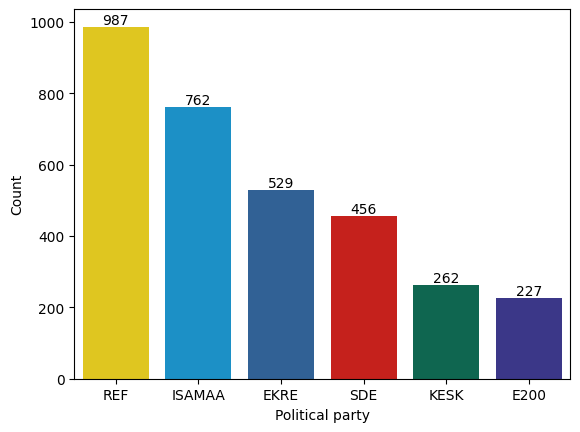

In [21]:
ax = sns.countplot(x = df_filtered2["erakond"], order = df_filtered2['erakond'].value_counts().index,
                  palette = [party_palette[0], party_palette[3], party_palette[4], party_palette[1],
                            party_palette[2], party_palette[5]])
#ax.set(title='Posts per party, before pre-processing')
plt.xlabel('Political party')
plt.ylabel('Count')
ax.bar_label(ax.containers[0])

plt.savefig('parties_after_preprocessing')

plt.show()

In [377]:
posters_df.to_frame().join(post_count_df).rename(columns = {'nimi': 'unique posters per party', 'erakond':'posts count per party'}).sort_values('posts count per party', ascending = False)

,unique posters per party,posts count per party
erakond,,
REF,10,987
ISAMAA,10,762
EKRE,9,529
SDE,10,456
KESK,9,262
E200,9,227


In [ ]:
# Calculate total number of posts for each group
group_person_counts = df_filtered2.groupby(['erakond', 'nimi']).size().reset_index(name='counts')

group_totals = group_person_counts.groupby('erakond')['counts'].sum().reset_index()
group_totals.columns = ['erakond', 'Total Posts per party']

group_person_counts = pd.merge(group_person_counts, group_totals, on='erakond')
group_person_counts['Percentage'] = round(group_person_counts['counts'] / group_person_counts['Total Posts per party'], 3) * 100


group_person_counts = group_person_counts.sort_values(['erakond', 'Percentage'], ascending=[True, False])
group_person_counts

In [38]:
parties = [ 'E200', 'Ekre', 'Isamaa', 'Keskerakond', 'Reformierakond', 'Sotsid']

# add new column with the modified names
group_person_counts['new_name'] = group_person_counts.apply(lambda x: x['nimi'] if x['nimi'] in parties else f"politician{group_person_counts[group_person_counts['erakond'] == x['erakond']]['nimi'].tolist().index(x['nimi']) + 1}", axis=1)

# remove name column
group_person_counts = group_person_counts[['erakond', 'counts', 'new_name']]

group_person_counts

,erakond,counts,new_name
0,E200,93,E200
4,E200,49,politician2
5,E200,33,politician3
8,E200,33,politician4
7,E200,6,politician5
2,E200,5,politician6
3,E200,3,politician7
6,E200,3,politician8
1,E200,2,politician9
13,EKRE,120,politician1


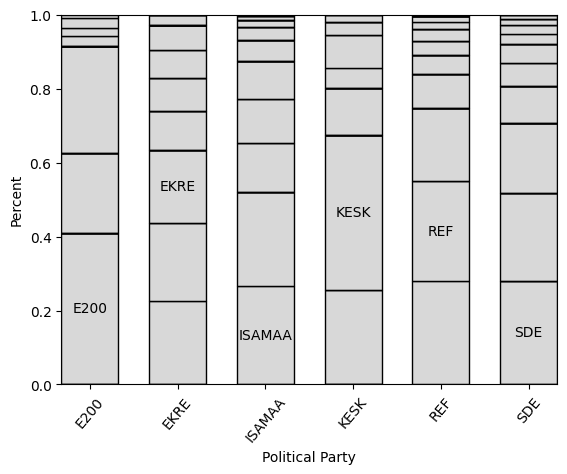

In [114]:
palette = ['#cccccc' for i in range(43)]
hist = sns.histplot(group_person_counts, x="erakond", hue="counts", weights='counts', palette=palette,
                    stat="percent", 
                    discrete=True,
                    multiple='fill', 
                    shrink=0.65, 
                    legend=False,
                   color='black')


#sns.move_legend(hist, "upper left", bbox_to_anchor=(1, 1))

plt.xticks(rotation=50)
plt.xlabel("Political Party")

labelMap = {
    10: 'E200',
    8: 'EKRE',
    2: 'ISAMAA',
    16: 'KESK',
    1: 'REF',
    4: 'SDE'
}

i = 0


for box in hist.containers:
    labels = [v.get_height() if v.get_height() > 0.15 else '' for v in box]
    if (i in labelMap):
        labels = [labelMap[i] if label != '' else '' for label in labels]
    labels = ['' if isinstance(label, float) else label for label in labels]
    
    hist.bar_label(box, labels=labels, label_type='center')
    i += 1
    


#plt.ylabel("Count")

plt.savefig('posts_dist_per_politician')
plt.show()

# https://seaborn.pydata.org/generated/seaborn.histplot.html

In [379]:
# save preprocessd+filtered file
df_filtered2.to_excel('leaders_preprocessed_filtered.xlsx', index = False)

## BERT preprocess

In [380]:
%%time

# remove emojis regex patterns
# https://gist.github.com/asl0007/9682f9f0795913b7d04522504e4f1093

emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

pattern = r"\s+(?=[\U0001F300-\U0001F64F])"
pattern2 = re.compile("[\U0001F600-\U0001F64F\u263A-\u27FF]+\s+")

# preprocessing function
def text_preprocess_bert(x):
    x = x.lower() # lower casing
    x = pattern2.sub(lambda m: m.group().replace(" ", ""), x) # remove spaces after emojis
    x = re.sub(pattern, "", x) # remove spaces before emojis
    x = emoji_pattern.sub(r'', x) # remove emojis
    x = re.sub(r'https*\S+', '', x) # remove urls
    x = x.replace("EST/RUS", "") # remove 'EST/RUS'
    x = re.sub(r'\p{Cyrillic}','', x) # remove text in russian/ukrainian
    x = re.sub(r'\n+', '', x) # remove \n
    x = re.sub(r'\s*([.,:;!?()])', r'\1', x) # Remove spaces before punctuation marks


    return x

df_filtered2['bert_text'] = df_filtered2['postitus'].apply(text_preprocess_bert)
df_filtered2['bert_text'] = df_filtered2['bert_text'].apply(remove_eng_words)

#subset['bertopic_text2'] = subset['postitus'].apply(text_preprocess_bertopic)
#subset['bertopic_text2'] = subset['bertopic_text2'].apply(remove_eng_words)


<timed exec>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: total: 19min 38s
Wall time: 19min 47s


<timed exec>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [385]:
# save file
df_filtered2.to_excel('leaders_bert.xlsx', index = False)

## 